# Inertia Gravity wave test case

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [183]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [168]:
mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/InertiaGravityWaveMesh",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic", nvlevels=3)
nothing

In [112]:
function DetermineInertiaGravityWaveExactSurfaceElevation(etaHat,kX,kY,omega,x,y,time)
    eta = etaHat*cos(kX*x + kY*y - omega*time)
    return eta
end

DetermineInertiaGravityWaveExactSurfaceElevation (generic function with 1 method)

In [113]:
function DetermineInertiaGravityWaveExactZonalVelocity(etaHat,f0,g,kX,kY,omega,x,y,time)
    u = etaHat*(g/(omega^2.0 - f0^2.0)*(omega*kX*cos(kX*x + kY*y - omega*time)
                                          - f0*kY*sin(kX*x + kY*y - omega*time)))
    return u
end

DetermineInertiaGravityWaveExactZonalVelocity (generic function with 1 method)

In [114]:
function DetermineInertiaGravityWaveExactMeridionalVelocity(etaHat,f0,g,kX,kY,omega,x,y,time)
    v = etaHat*(g/(omega^2.0 - f0^2.0)*(omega*kY*cos(kX*x + kY*y - omega*time)
                                          + f0*kX*sin(kX*x + kY*y - omega*time)))
    return v
end

DetermineInertiaGravityWaveExactMeridionalVelocity (generic function with 1 method)

In [115]:
meanCoriolisParameterf = sum(mpasOcean.fCell) / mpasOcean.nCells

0.0010000000000000007

In [116]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

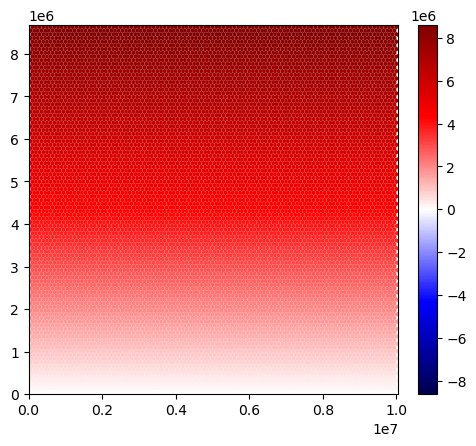

In [117]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.yCell)
display(fig)


$ \pmatrix{\eta\\ u\\ v } = Real( \pmatrix{A\\ U\\ V} e^{i ( k_x x + k_y y - \omega t) } ) $

$ \frac{\partial \eta}{\partial t} = Imag(-w A e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial u}{\partial x} = Imag(k_x U e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial v}{\partial y} = Imag(k_y V e^{i ( k_x x + k_y y - \omega t) }) $

$ \frac{\partial \eta}{\partial t} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $



In [118]:
kx = 4 * 2*pi / mpasOcean.lX
U = 2.0e-3

ky = 3  * 2*pi / mpasOcean.lY
V = 4.5e-4

k = sqrt(kx^2 + ky^2)

w = sqrt(meanCoriolisParameterf^2 + mpasOcean.gravity*meanFluidThicknessH*k^2)
A = (kx*U + ky*V) / w

kx, U, ky, V, w, A, kx*U + ky*V + w*A

(2.5132741228718346e-6, 0.002, 2.1765592370810614e-6, 0.00045, 0.0010527719496198397, 5.704939141472128e-6, 1.2011999804860293e-8)

In [119]:
maximum(mpasOcean.angleEdge)

5.235987755982989

In [120]:
function inertiaGravityInit!(mpasOcean, t=0; kx=kx, U=U, ky=ky, V=V, w=w, A=A)
    for iCell in 1:mpasOcean.nCells
        x = mpasOcean.xCell[iCell]
        y = mpasOcean.yCell[iCell]
        
        mpasOcean.sshCurrent[iCell] = A*cos(kx*x + ky*y - w*t)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        x = mpasOcean.xEdge[iEdge]
        y = mpasOcean.yEdge[iEdge]
        
#         u = U*cos(kx*x + ky*y - w*t)
        u = DetermineInertiaGravityWaveExactZonalVelocity(A, meanCoriolisParameterf, mpasOcean.gravity, kx, ky, w, x, y, t)
        
#         v = V*cos(kx*x + ky*y - w*t)
        v = DetermineInertiaGravityWaveExactMeridionalVelocity(A, meanCoriolisParameterf, mpasOcean.gravity, kx, ky, w, x, y, t)
        
        theta = mpasOcean.angleEdge[iEdge]
        
        mpasOcean.normalVelocityCurrent[iEdge,:] .= u*cos(theta) + v*sin(theta)
    end
end

inertiaGravityInit! (generic function with 2 methods)

In [185]:
inertiaGravityInit!(mpasOcean)

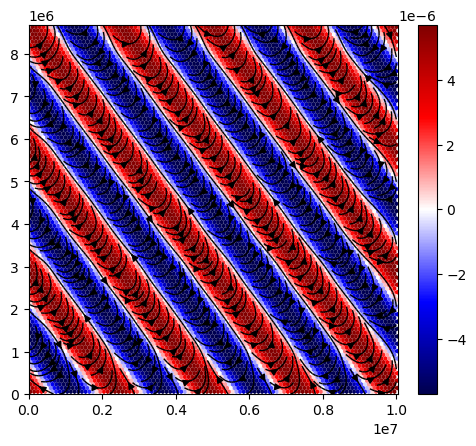

In [186]:
fig, ax, cbar, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
vectorStreamPlotMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig, ax=ax, cbar=cbar, xbins=17, ybins=13)
display(fig)

In [171]:
mpasOcean.normalVelocityCurrent

30000×3 Matrix{Float64}:
 -3.36142e-7  -3.36142e-7  -3.36142e-7
 -7.48431e-7  -7.48431e-7  -7.48431e-7
  1.15917e-7   1.15917e-7   1.15917e-7
  9.51589e-7   9.51589e-7   9.51589e-7
  1.29232e-6   1.29232e-6   1.29232e-6
  1.55185e-6   1.55185e-6   1.55185e-6
  1.71387e-6   1.71387e-6   1.71387e-6
  1.71144e-6   1.71144e-6   1.71144e-6
  9.43314e-7   9.43314e-7   9.43314e-7
  5.41745e-7   5.41745e-7   5.41745e-7
  1.06136e-7   1.06136e-7   1.06136e-7
 -1.75488e-6  -1.75488e-6  -1.75488e-6
 -7.48431e-7  -7.48431e-7  -7.48431e-7
  ⋮                        
 -1.71887e-6  -1.71887e-6  -1.71887e-6
  8.09833e-7   8.09833e-7   8.09833e-7
 -1.13087e-6  -1.13087e-6  -1.13087e-6
  1.77378e-6   1.77378e-6   1.77378e-6
  1.18332e-6   1.18332e-6   1.18332e-6
 -1.78835e-6  -1.78835e-6  -1.78835e-6
 -7.62988e-7  -7.62988e-7  -7.62988e-7
  1.13087e-6   1.13087e-6   1.13087e-6
  7.57299e-7   7.57299e-7   7.57299e-7
 -1.28561e-6  -1.28561e-6  -1.28561e-6
 -3.98531e-7  -3.98531e-7  -3.98531e-7
  3.36142e-

# Simulate wave

In [187]:
2*pi/(w*mpasOcean.dt) # number of timesteps per cycle of wave

59.082464304523825

In [188]:
nFrames = 15

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

interval = 5

for i in 1:nFrames
    for j in 1:interval
        forward_backward_step!(mpasOcean)
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

## animate simulation

In [189]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f8a9db8ffd0>

In [190]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# animate exact solution

In [177]:
sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))

t = 0

for i in 1:nFrames
    t += interval* mpasOcean.dt
    inertiaGravityInit!(mpasOcean, t)
    sshOverTimeExact[i,:] .= mpasOcean.sshCurrent[:]
end

In [178]:
cMax = maximum(abs.(sshOverTimeExact))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f8a9f8bab20>

In [179]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# show numerical error

In [180]:
sshError = (sshOverTime .- sshOverTimeExact)

cMax = maximum(abs.(sshOverTimeExact))

fig, ax, _, col = heatMapMesh(mpasOcean, sshError[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshError[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f8a9e946430>

In [181]:
sshError

30×10000 Matrix{Float64}:
 7.95374e-7  7.53099e-7  6.63503e-7  5.32218e-7  …   7.08804e-7   7.77927e-7
 3.10457e-6  3.08088e-6  2.86361e-6  2.4664e-6       2.46217e-6   2.86086e-6
 6.49753e-6  6.74271e-6  6.56422e-6  5.97328e-6      4.51796e-6   5.62122e-6
 1.02449e-5  1.11296e-5  1.13149e-5  1.07893e-5      6.05055e-6   8.24433e-6
 1.35196e-5  1.54322e-5  1.63752e-5  1.62893e-5      6.37876e-6   9.95345e-6
 1.56248e-5  1.88647e-5  2.09193e-5  2.16595e-5  …   5.15401e-6   1.02242e-5
 1.61869e-5  2.08814e-5  2.42638e-5  2.61217e-5      2.45654e-6   8.92942e-6
 1.52582e-5  2.13275e-5  2.60566e-5  2.91486e-5     -1.22674e-6   6.37421e-6
 1.33028e-5  2.04819e-5  2.63741e-5  3.06091e-5     -5.13669e-6   3.21176e-6
 1.10682e-5  1.89804e-5  2.57e-5     3.08048e-5     -8.45159e-6   2.62909e-7
 9.37916e-6  1.76397e-5  2.4792e-5   3.03864e-5  …  -1.0514e-5   -1.71046e-6
 8.90959e-6  1.72322e-5  2.44721e-5  3.01743e-5     -1.10124e-5  -2.21584e-6
 9.99678e-6  1.82726e-5  2.54003e-5  3.09319e-5   

In [182]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>